# Practical 6: Deep Learning for Multiclass Text Classification
### Instructor:  Dr. Maryam Movahedifar

<div style="display: flex; justify-content: space-between; align-items: center;">
  <span style="display: flex; align-items: center;">
    <b>Applied Text Mining - University of Bremen - Data Science Center</b>
  </span>
  <div style="display: flex; align-items: center; margin-left: auto;">
    <img src="Uni_Logo.png" alt="Uni Logo" style="width: 100px; margin-right: 10px;">
    <img src="DSC_Logo.png" alt="DSC Logo" style="width: 150px;">
  </div>
</div>

In this practical, we will apply various deep learning models for multiclass text classification. We will work with the famous 20 Newsgroups dataset from the `sklearn` library and apply deep learning models using the `keras` library.

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It was originally collected by Ken Lang, and it has become a popular data set for experiments in text applications of machine learning techniques.

Also, we will use the keras library, which is a deep learning and neural networks API by François Chollet's team capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft).

Today we will use the following libraries. Take care to have them installed!

In [1]:
!rm -rf ~/.cache

In [2]:
!pip install --upgrade scikit-learn scikeras tensorflow keras matplotlib pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers, Input

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


2025-07-10 15:41:16.782669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 15:41:16.784973: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 15:41:16.793042: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 15:41:16.808138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752154876.827412   33887 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752154876.83

# Let's Get Started!

1. **Load the train and test subsets** of the 20 Newsgroups dataset from `sklearn.datasets`.

- **Preprocess the data**:
   - Remove the **headers**, **footers**, and **quotes** from the articles when loading the dataset.
   - Use `random_state=321` for reproducibility.

- **Subset the data** to only include the following 5 categories (to reduce execution time):
   - `rec.sport.hockey`
   - `talk.politics.mideast`
   - `soc.religion.christian`
   - `comp.graphics`
   - `sci.med`


In [4]:
categories = ['rec.sport.hockey', 'talk.politics.mideast', 'soc.religion.christian', 'comp.graphics', 'sci.med']

In [5]:
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),
                                  categories=categories, shuffle=True, random_state=321)


In [6]:
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),
                                 categories=categories, shuffle=True, random_state=321)

2. **Find out about the number of news articles in the train and test sets.**

In [7]:
twenty_train.target_names

['comp.graphics',
 'rec.sport.hockey',
 'sci.med',
 'soc.religion.christian',
 'talk.politics.mideast']

In [8]:
twenty_train.filenames.shape

(2941,)

In [9]:
twenty_test.filenames.shape

(1958,)

In [10]:
df_train = pd.DataFrame(list(zip(twenty_train.data, twenty_train.target)), columns=['text', 'label'])
df_train.head()

,text,label
0,\nDr. cheghadr bA namakand! They just wait un...,4
1,\n\n\n\n\n:) No...I was one of the lucky ones....,2
2,\n\n[After a small refresh Hasan got on the tr...,4
3,Before getting excited and implying that I am ...,4
4,I have posted disp135.zip to alt.binaries.pict...,0


In [11]:
df_test = pd.DataFrame(list(zip(twenty_test.data, twenty_test.target)), columns=['text', 'label'])
df_test.head()

,text,label
0,"hi all, Ive applied for the class of 93 at qui...",2
1,:In article <enea1-270493135255@enea.apple.com...,2
2,"\nI don't know the answer the to this one, alt...",0
3,\n\nWe here at IBM have the same problem with ...,0
4,\nI was at an Adobe seminar/conference/propaga...,0


## Train a Neural Network with a Document-Term Matrix

4. **To train a predictive deep learning model with text data, the text must first be converted into numerical vectors suitable for statistical analysis.**

   - Use **`TfidfVectorizer`** from `sklearn.feature_extraction.text`.
   - Apply the **binary representation** by setting `binary=True`.
   - Create **document-term matrices** for the training and test datasets.
   - Name the resulting matrices:
     - `X_train` for the training set
     - `X_test` for the test set


In [12]:
# A function for transforming train or test into tfidf features

def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float32')  # float16 is not supported for sparse matrices
    return x

tfidf = TfidfVectorizer(binary=True)
X_train = tfidf_features(df_train.text.values, flag="train")
X_test = tfidf_features(df_test.text.values, flag="test")


# With CountVectorizer and without the function
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer()
# X_train = count_vect.fit_transform(df_train.text.values)
# X_test = count_vect.transform(df_test.text.values)

In [13]:
X_train.nnz / float(X_train.shape[0])

111.5678340700442

The extracted vectors are very sparse, with an average of 111 non-zero components by sample in a more than 37000-dimensional space (less than 0.3% non-zero features)

In [14]:
X_test.nnz / float(X_train.shape[0])

75.78748724923496

In [15]:
#tfidf.vocabulary_

5. **Use the `LabelEncoder` to create `y_train` and `y_test` from `df_train.label.values` and `df_test.label.values`, respectively.**

   - `LabelEncoder` is used to convert the text labels into numeric format, which is required for model training.
   - Store the encoded labels as:
     - `y_train` for the training labels
     - `y_test` for the test labels


In [16]:
# Converting the list of strings to the matrix of vectors (to be fed neural network models)
# Encode the list of newsgroups into categorical integer values
lb = LabelEncoder()
y = lb.fit_transform(df_train.label.values)
y_train = to_categorical(y)


In [17]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [18]:
y_train.shape

(2941, 5)

In [19]:
y = lb.transform(df_test.label.values)
y_test = to_categorical(y)


6. **Use the Sequential API in Keras to create a one-hidden-layer neural network:**

   - The first layer should be the input layer with the number of features in your `X_train`.
   - Add a single hidden layer with:
     - **5 neurons**
     - **ReLU activation function**
   - Add an output layer with a **softmax activation function** suitable for multi-class classification.

The **Sequential API** ([Keras Sequential Model Guide](https://www.tensorflow.org/guide/keras/sequential_model)) allows you to build models layer-by-layer. It is straightforward but limited, as it does not support models with shared layers or multiple inputs/outputs.

In contrast, the **Functional API** ([Keras Functional API Guide](https://www.tensorflow.org/guide/keras/functional)) offers more flexibility, enabling you to define models with complex architectures — including models with multiple inputs and outputs or layers connected in arbitrary ways. This is useful for advanced networks such as Siamese networks or residual networks.


In [20]:
model = Sequential()
input_dim = X_train.shape[1]  # Number of features
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-10 15:41:23.615659: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


7. **The `compile` function defines the loss function, optimizer, and evaluation metrics for your neural network model.**

- Compile your model using:
  - `loss='binary_crossentropy'`
  - `optimizer='adam'`
  - `metrics=['accuracy']`

- After compiling, check the summary of the model using the `.summary()` method.


In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │       371,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,545 (1.42 MB)

 Trainable params: 371,545 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

8. **Time to train your model!**

- Train your model for **20 epochs** (iterations over the entire training data).
- Use the `batch_size` parameter during training.

**What does `batch_size` represent?**

- `batch_size` is the number of training samples processed before the model's internal parameters are updated.
- Smaller batch sizes can lead to more noisy updates but potentially better generalization.
- Larger batch sizes result in faster computation but require more memory and may lead to less frequent updates.



In [22]:
history = model.fit(X_train, y_train, epochs=20, batch_size=512)
# model.save_weights("model.h5")
# print("Saved model to disk")

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.2569 - loss: 0.6909
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.4376 - loss: 0.6793
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.5174 - loss: 0.6665
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.5287 - loss: 0.6527
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.5292 - loss: 0.6388
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.5631 - loss: 0.6228
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5674 - loss: 0.6086
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.5766 - loss: 0.5924
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.5982 - loss: 0.5757
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6073 - loss: 0.5607
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.6127 - loss: 0.5458
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.6289 - lo

**Note:** If you rerun the `fit()` method on your model, training will continue starting from the weights computed during the previous training session.

To reset and start fresh training (i.e., reinitialize the model weights), make sure to call `clear_session()` before you begin training again:

```python
from keras.backend import clear_session
clear_session()


9. **Plot the accuracy and loss of your trained model.**

dict_keys(['accuracy', 'loss'])


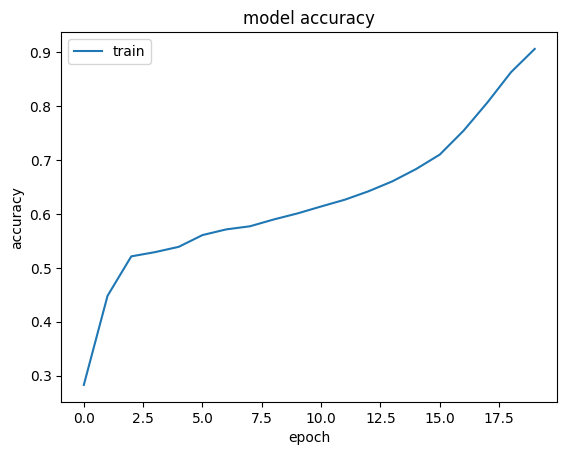

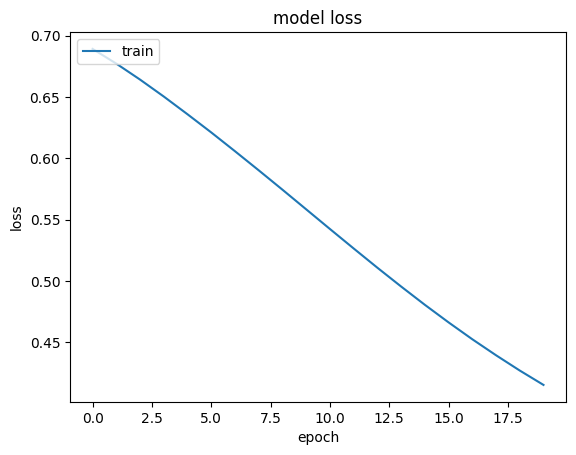

In [23]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# Here we converted the code to a function so we can use it later as well
plt.style.use('ggplot')

def plot_history(history, val=0):
    acc = history.history['accuracy']
    if val == 1:
        val_acc = history.history['val_accuracy'] # we can add a validation set in our fit function with nn
    loss = history.history['loss']
    if val == 1:
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    if val == 1:
        plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val == 1:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

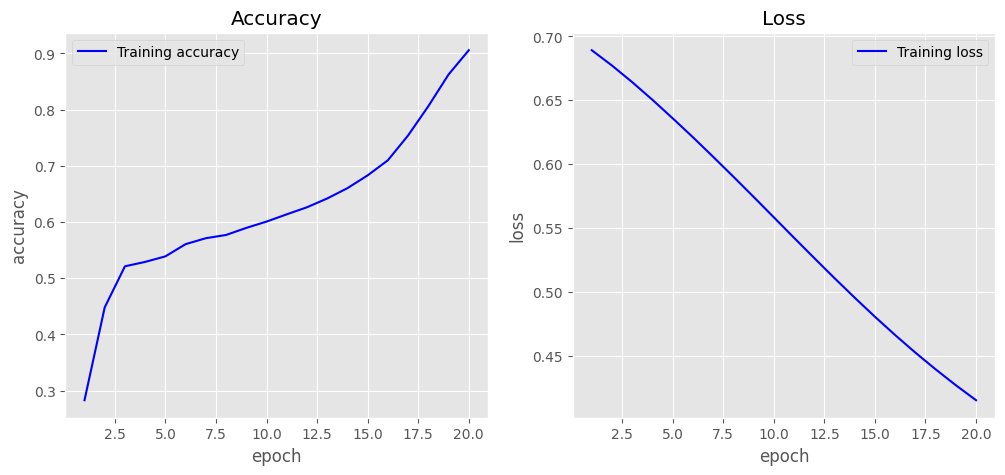

In [25]:
plot_history(history)

10. **Evaluate the accuracy of your trained model on the test set. Compare that with the accuracy on train.**

In [26]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss,accuracy))

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7440 - loss: 0.4414
Test set
  Loss: 0.440
  Accuracy: 0.749


You can already see that the model was overfitting since it reached over 70% accuracy for the training set (Big gap between training accuracy (high) and validation/test accuracy (low).). When training a model, you can use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

# The Embedding Layer

Here, we want to create a Sequential model with an **embedding layer** as the input layer, followed by dense layers. 

To do this, we first need to apply the **Tokenizer** from Keras and convert the text data into sequences that can be passed into the embedding layer.

11. **Use the Keras `Tokenizer` with a vocabulary size of **20,000 words** to create `X_train` and `X_test` sequences from the text data.**


In [27]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train.text.values)

In [28]:
X_train = tokenizer.texts_to_sequences(df_train.text.values)
X_test = tokenizer.texts_to_sequences(df_test.text.values)

In [29]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for sequence padding
vocab_size

38111

**Note:**  
A document-term matrix uses vectors of **word counts**, where each vector has the same length — the size of the total corpus vocabulary.

With Keras `Tokenizer`, however, the resulting vectors correspond to the **length of each text** (which can vary), and the numbers represent the **word indices** from the tokenizer’s vocabulary (`tokenizer.word_index`), not the counts of words.


In [30]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 35
happy: 1043
sad: 3422


12. **Use the `pad_sequence()` function to pad each text sequence with zeros, so that each vector has the same length of 100 words.**

In [31]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [32]:
print(X_train[0, :])

[  555 12221    23    75  1507   379    23    16 15253     3   621    63
  5371 10293    73  2745     5   246   686     2 10294     2  2340     4
  3927     6   332  4110  1290     3 12222   131    37     2     1    72
  7235    34   177    21     7  3928     4    33    16    35    86 12223
  3226     4    23   241   753     3 12222     3    47    38  7953    42
     4    93    17   364     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


Typically, it does not matter whether you prepend or append zeros during sequence padding. The first values represent the indices in the vocabulary, and the rest are zeros added by padding because the document is shorter than the fixed sequence length.

13. **Now it is time to create a neural network model using an **embedding layer** as the input layer.**

- Use an embedding dimension of **50** (`embedding_dim = 50`).
- Connect the output of the embedding layer to a **Dense layer** with:
  - **10 neurons**
  - **ReLU activation function**
- Add a **Flatten layer** between the embedding layer and the Dense layer to prepare the sequential output for the Dense layer.

**Note:**  
- In the `Embedding` layer:
  - `input_dim` is the size of the vocabulary.
  - `output_dim` is the size of the embedding vector.
  - `input_length` is the length of the input text sequences.


In [33]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

# ✅ Build the model with the expected input shape
model.build(input_shape=(None, maxlen))

# Now you can see the full model summary
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │     1,905,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        50,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,955,615 (7.46 MB)

 Trainable params: 1,955,615 (7.46 MB)

 Non-trainable params: 0 (0.00 B)

You can now see that we have 1,905,550 new parameters to train. This number comes from vocab_size (38,111) times the embedding_dim (50). These weights of the embedding layer are randomly initialized and then are adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors.

In [34]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)


In [35]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9725
Testing Accuracy:  0.7686


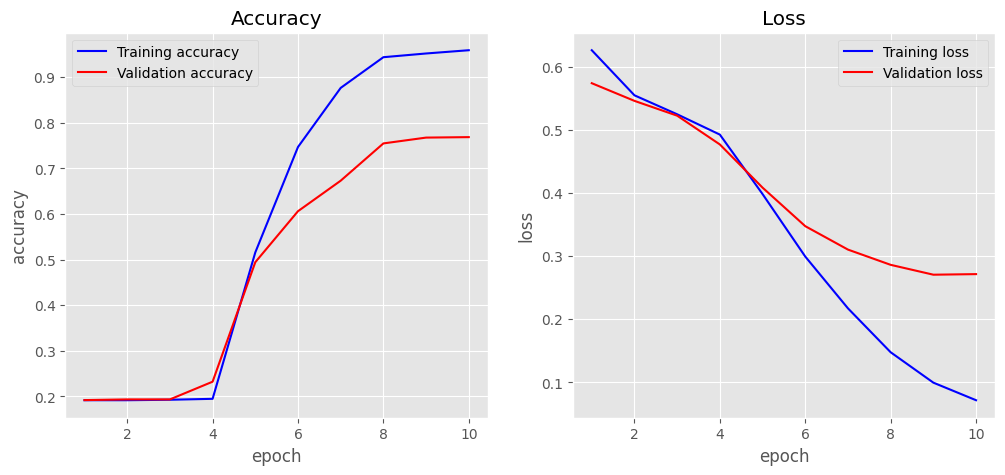

In [36]:
plot_history(history, val=1)

# Pretrained Word Embeddings

14. Pretrained word embeddings are embeddings learned on one task and reused to solve another similar task. These embeddings are trained on large datasets, saved, and then applied to other tasks to leverage learned semantic information.

In this practical, we will use **GloVe embeddings** — precomputed word vectors trained on a large corpus of text.

- Download one of the GloVe embeddings files (e.g., `glove.6B.50d.txt`) from [this link](https://nlp.stanford.edu/projects/glove/).
- Use the provided function to load the pretrained embeddings and create an **embedding matrix** that matches the words in your vocabulary.

This embedding matrix can then be used to initialize the weights of the embedding layer in your model.


In [37]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [38]:
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           tokenizer.word_index, embedding_dim = 50)

In [39]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7771771929364225

15. **Build your previous neural network model again, but this time initialize the embedding layer with the pretrained word embeddings from the GloVe embedding matrix.**

- Set the `trainable` argument of the embedding layer to `False` initially so that the embedding weights are **frozen** during training (i.e., the model does not update the pretrained embeddings).
- Train the model and evaluate its performance.
- Then set `trainable=True` on the embedding layer, allowing the model to **fine-tune** the embeddings during training.
- Train the model again and compare the performances.

**Question:**  
How does freezing versus fine-tuning the pretrained embeddings affect the model’s performance?


In [40]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

# ✅ Build the model with the expected input shape
model.build(input_shape=(None, maxlen))

# Now you can see the full model summary


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 50)        │     1,905,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,906,115 (7.27 MB)

 Trainable params: 565 (2.21 KB)

 Non-trainable params: 1,905,550 (7.27 MB)

Training Accuracy: 0.7831
Testing Accuracy:  0.7712


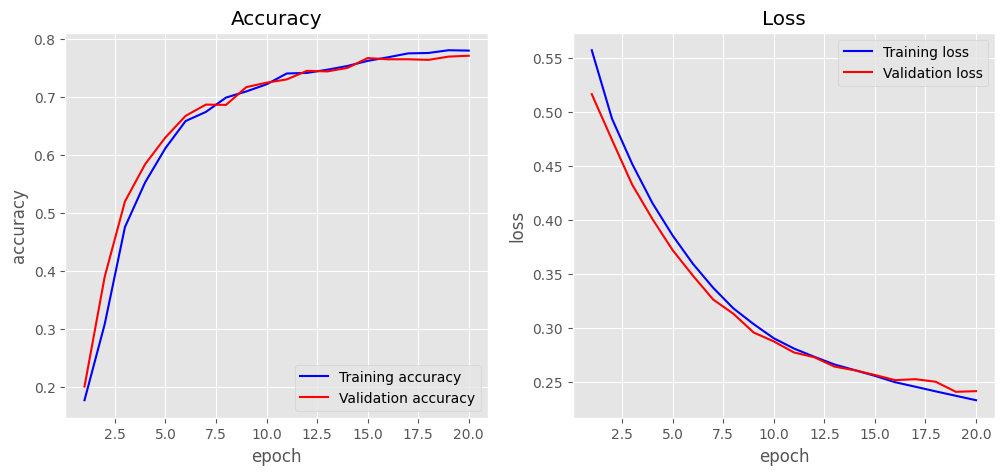

In [41]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using `trainable=True:`

In [42]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

# ✅ Build the model with the expected input shape
model.build(input_shape=(None, maxlen))

# Now you can see the full model summary
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 50)        │     1,905,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,906,115 (7.27 MB)

 Trainable params: 1,906,115 (7.27 MB)

 Non-trainable params: 0 (0.00 B)

Because it is a multiclass classification problem, log loss is used as the loss function (`categorical_crossentropy` in `keras`). The efficient ADAM optimization algorithm is used. The model is fit for 20 epochs. A large batch size of 64 reviews is used to space out weight updates.

Training Accuracy: 0.9782
Testing Accuracy:  0.8330


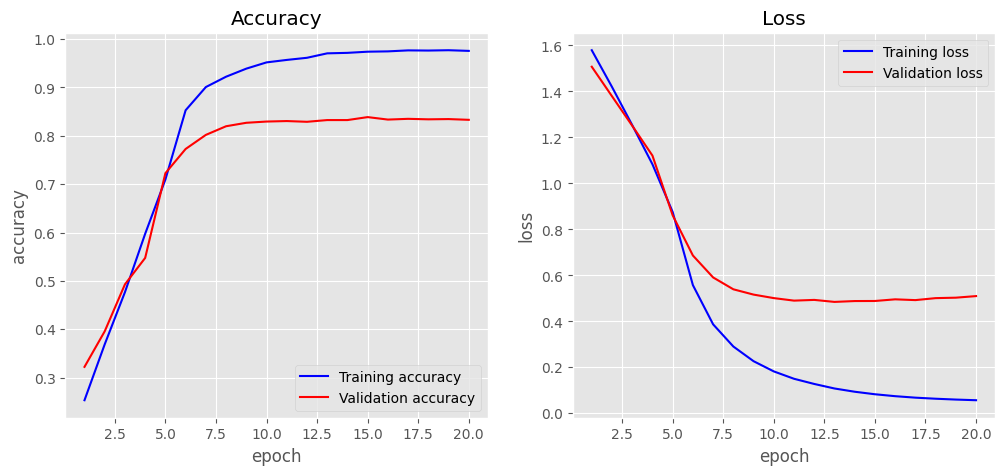

In [43]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)